这个分析笔记由[Jake Vanderplas](http://www.vanderplas.com)编辑汇总. 源代码和license文件在[GitHub](https://github.com/jakevdp/sklearn_tutorial/)。 中文翻译由[派兰数据](http://datarx.cn)在[派兰大数据分析平台](http://palandata.com)上完成。

# 密度估计：高斯混合模型

我们在这里将会讨论 **高斯混合模型**，它是一个无监督聚类和密度估计的算法。

我们首先进行基本的设置：

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

## 高斯混合模型介绍

我们之前看过K-Means的例子，它是一个使用EM方法的聚类算法。

在这里我们需要考虑一个既适用于**聚类**也适用于**密度估计**的方法。

举个例子，我们现在有一个呈某种分布的一维数据：

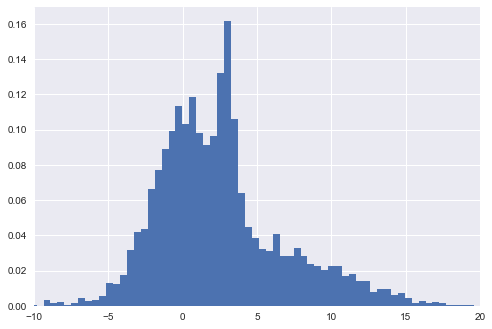

In [2]:
np.random.seed(2)
x = np.concatenate([np.random.normal(0, 2, 2000),
                    np.random.normal(5, 5, 2000),
                    np.random.normal(3, 0.5, 600)])
plt.hist(x, 80, normed=True)
plt.xlim(-10, 20);

高斯混合模型可以帮助我们近似数据密度：

/Users/linyong/anaconda/envs/pydata/lib/python3.6/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/linyong/anaconda/envs/pydata/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/linyong/anaconda/envs/pydata/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/linyong/anaconda/envs/pydata/l

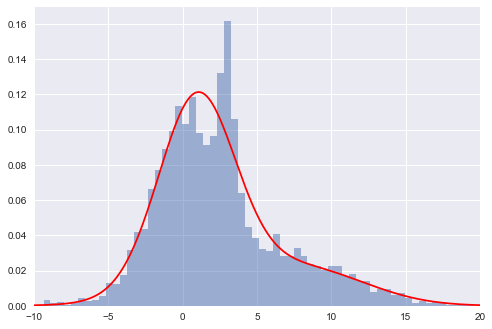

In [4]:
from sklearn.mixture import GMM
X = x[:, np.newaxis]
clf = GMM(4, n_iter=500, random_state=3).fit(X)
xpdf = np.linspace(-10, 20, 1000)
density = np.exp(clf.score(xpdf[:, np.newaxis]))

plt.hist(x, 80, normed=True, alpha=0.5)
plt.plot(xpdf, density, '-r')
plt.xlim(-10, 20);

我们注意到，这个密度是由**混合高斯**算法估计的，我们可以通过看它的 ``means_``, ``covars_``, 和 ``weights_`` 参数进行校验：

In [5]:
clf.means_

array([[ 0.25306823],
       [ 3.96038601],
       [ 1.45350312],
       [ 9.56303626]])

In [6]:
clf.covars_

array([[  6.4601766 ],
       [ 23.19014431],
       [  5.80884786],
       [ 14.79998213]])

In [7]:
clf.weights_

array([ 0.31823886,  0.21876416,  0.35341345,  0.10958354])

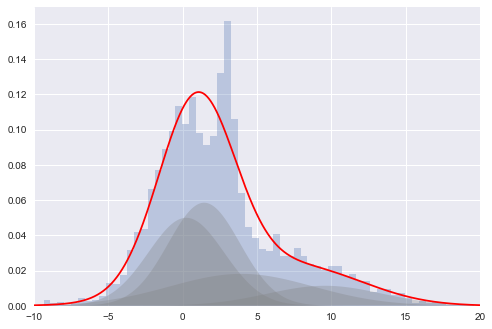

In [8]:
plt.hist(x, 80, normed=True, alpha=0.3)
plt.plot(xpdf, density, '-r')

for i in range(clf.n_components):
    pdf = clf.weights_[i] * stats.norm(clf.means_[i, 0],
                                       np.sqrt(clf.covars_[i, 0])).pdf(xpdf)
    plt.fill(xpdf, pdf, facecolor='gray',
             edgecolor='none', alpha=0.3)
plt.xlim(-10, 20);

这些独立的高斯分布是用EM算法估计的，除了对数据类别的规定，其他就像在K-means中一样。后验概率是用来计算加权平均数和协方差的。
有些让人惊讶的是，这个算法被证明可以在最优值处收敛(虽然并不需要达到全局最优)。

## 有多少高斯分布？

给出一个模型，我们可以用以下的几种方法之一去评估这个模型对数据拟合的效果。
举个例子，这里有赤池信息量(AIC)和贝叶斯信息量(BIC)两种度量方法。

In [9]:
print(clf.bic(X))
print(clf.aic(X))

25911.1937804
25840.421853


/Users/linyong/anaconda/envs/pydata/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/linyong/anaconda/envs/pydata/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


让我们来看一下模型的优劣随着高斯分布数的改变会有什么变化：

/Users/linyong/anaconda/envs/pydata/lib/python3.6/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/linyong/anaconda/envs/pydata/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/linyong/anaconda/envs/pydata/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/linyong/anaconda/envs/pydata/l

/Users/linyong/anaconda/envs/pydata/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/linyong/anaconda/envs/pydata/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/linyong/anaconda/envs/pydata/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/liny

/Users/linyong/anaconda/envs/pydata/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/linyong/anaconda/envs/pydata/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/linyong/anaconda/envs/pydata/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/liny

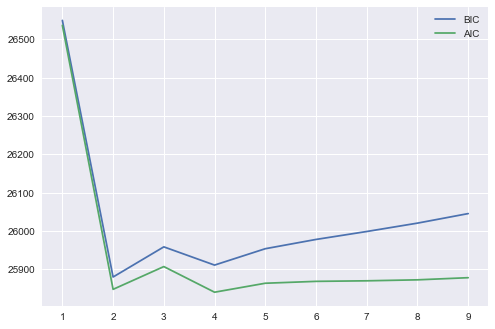

In [10]:
n_estimators = np.arange(1, 10)
clfs = [GMM(n, n_iter=1000).fit(X) for n in n_estimators]
bics = [clf.bic(X) for clf in clfs]
aics = [clf.aic(X) for clf in clfs]

plt.plot(n_estimators, bics, label='BIC')
plt.plot(n_estimators, aics, label='AIC')
plt.legend();

从图中我们可以看到，无论是AIC还是BIC，4个高斯分布的情况是最好的。

## 例子：GMM在异常检测中的应用

GMM就是所谓的**生成模型**：它是一个概率模型，通过这个模型我们可以生成一个数据集。
对于异常检测，GMM在以下这个方面会有作用：我们可以在生成模型下简单的评估每一个点的概率；那些具有相对低的概率的点可以被视为是异常数据(相对的标准是由您的对偏置和方差的偏好来决定的)。

我们通过创建一个带异常数据的数据集来看一看他的应用：

In [11]:
np.random.seed(0)

# Add 20 outliers
true_outliers = np.sort(np.random.randint(0, len(x), 20))
y = x.copy()
y[true_outliers] += 50 * np.random.randn(20)

/Users/linyong/anaconda/envs/pydata/lib/python3.6/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/linyong/anaconda/envs/pydata/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/linyong/anaconda/envs/pydata/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/linyong/anaconda/envs/pydata/l

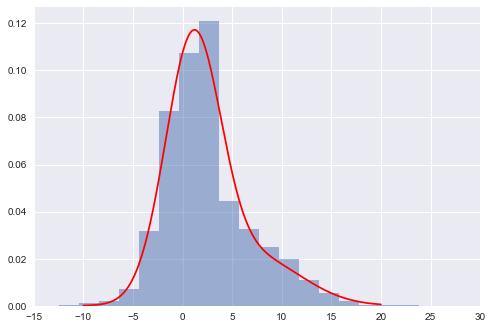

In [12]:
clf = GMM(4, n_iter=500, random_state=0).fit(y[:, np.newaxis])
xpdf = np.linspace(-10, 20, 1000)
density_noise = np.exp(clf.score(xpdf[:, np.newaxis]))

plt.hist(y, 80, normed=True, alpha=0.5)
plt.plot(xpdf, density_noise, '-r')
plt.xlim(-15, 30);

现在我们来评估一下在生成模型下，每个点出现的概率，我们将这些点作为``y``的函数画出来。

/Users/linyong/anaconda/envs/pydata/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


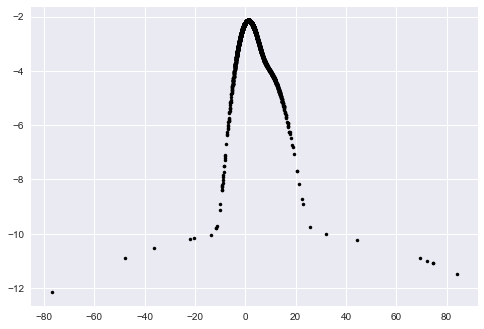

In [13]:
log_likelihood = clf.score_samples(y[:, np.newaxis])[0]
plt.plot(y, log_likelihood, '.k');

In [14]:
detected_outliers = np.where(log_likelihood < -9)[0]

print("true outliers:")
print(true_outliers)
print("\ndetected outliers:")
print(detected_outliers)

true outliers:
[  99  537  705 1033 1653 1701 1871 2046 2135 2163 2222 2496 2599 2607 2732
 2893 2897 3264 3468 4373]

detected outliers:
[  99  537  705 1653 2046 2135 2163 2222 2496 2732 2893 2897 3067 3173 3253
 3468 3483 4373]


这个算法漏掉了一些期望的异常点(有一些异常点甚至实际上处在整个分布的中央！)

下面这些异常数据被忽视了：

In [15]:
set(true_outliers) - set(detected_outliers)

{1033, 1701, 1871, 2599, 2607, 3264}

还有一些点被错误的估计成了异常点：

In [16]:
set(detected_outliers) - set(true_outliers)

{3067, 3173, 3253, 3483}

最后，我们需要注意，虽然上面的所有处理都是针对一维数据的。GMM实际上生成了多维的数据，我们将在后面的部分看到。

## 其他的密度估计算法

这儿也有一些其他的主流算法，比如*核密度估计*，您可以在``sklearn.neighbors.KernelDensity`` 中获得。从某种程度上来说，这个可以被认为是GMM的一个生成模型，其中每一个训练点的位置都存在一个高斯核！

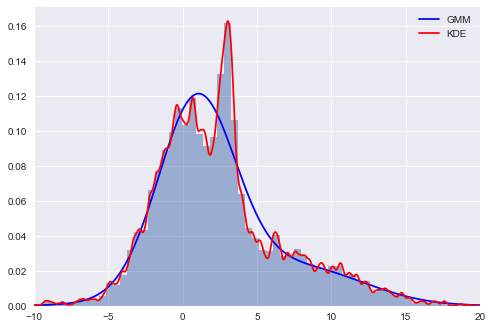

In [17]:
from sklearn.neighbors import KernelDensity
kde = KernelDensity(0.15).fit(x[:, None])
density_kde = np.exp(kde.score_samples(xpdf[:, None]))

plt.hist(x, 80, normed=True, alpha=0.5)
plt.plot(xpdf, density, '-b', label='GMM')
plt.plot(xpdf, density_kde, '-r', label='KDE')
plt.xlim(-10, 20)
plt.legend();

所有这些密度估计的方法都可以被称为是数据的**生成模型**：也就是，这个模型会告诉我们怎样生成更多的符合模型特征的数据。